## Students
Please fill in your names and S/U-numbers:
* Linda Schmeitz, S1042449
* Enrico Schmitz, s1047521
* Charlotte Cambier van Nooten, s1044122

# Statistical Machine Learning 2020
# Assignment 4
# Deadline: 23 December 2020
## Instructions
* You can __work in groups__ (= max 3 people). __Write the full name and S/U-number of all team members in the header above.__
* Make sure you __fill in any place that says__ `YOUR CODE HERE` or "YOUR ANSWER HERE" __including comments, derivations, explanations, graphs, etc.__ This means that the elements and/or intermediate steps required to derive the answer have to be in the report. (Answers like 'No' or 'x=27.2' by themselves are not sufficient, even when they are the result of running your code.) If an exercise requires coding, explain briefly what the code does (in comments). All figures should have titles (descriptions), axis labels, and legends (if applicable).
* Please do not add new cells unless necessary, try to write the answers only in the provided cells. Before you turn this problem in, __make sure everything runs as expected__. First, *restart the kernel* (in the menubar, select Kernel$\rightarrow$Restart) and then *run all cells* (in the menubar, select Cell$\rightarrow$Run All). The assignment was written in (and we strongly recommend using) Python 3 by using the corresponding Python 3 kernel for Jupyter.
* The assignment includes certain cells that contain tests. Most of the tests are marked as *hidden* and are used for automatic grading. NB: These hidden tests do not provide any feedback! There are also a couple of tests / checks that are visible, which are meant to help you avoid basic coding errors.
* __Upload the exercises to Brightspace as a single .zip file containing the submitter's S/U-number: 'SML20_as04_&lt;S/U-number&gt;.zip'__, for example 'SML20_as04_S123456.zip'. For those working in groups, it is sufficient if one team member uploads the solutions.
* For any problems or questions, send us an email, or just ask. Email addresses: G.Bucur@cs.ru.nl, Yuliya.Shapovalova@ru.nl, and tomc@cs.ru.nl.

## Introduction
Assignment 4 consists of:
1. Gaussian processes (50 points);
2. EM and doping (50 points);
3. Gibbs sampling and Metropolis-Hastings (50 points);
4. __Variational inference for Bayesian linear regression (50 points)__.

## Libraries
First, we import the basic libraries necessary to develop this assignment. Of course you are free to import further libraries, if required, in the allotted cells.

In [1]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it to at least version 3."

import numpy as np
import matplotlib.pyplot as plt
import itertools
import functools

# Set fixed random seed for reproducibility
np.random.seed(2020)

## Variational inference for Bayesian linear regression
In this assignment we will consider variational inference for Bayesian linear regression. Using variational inference we can find an approximate posterior distribution of the parameters of interest. While generally there is no need for variational inference in linear regression problems, it is useful to derive it and implement it for a better understanding.

Recall the likelihood function for $\mathbf{w}$
$$
p(\mathbf{t}|\mathbf{w}) = \prod_{n=1}^{N}N(t_{n}|\mathbf{w}^{T}\phi_{n}, \beta^{-1}) 
$$
and the prior over $\mathbf{w}$
$$
p(\mathbf{w}|\alpha) = N(\mathbf{w}|0, \alpha^{-1}\mathbf{I}),
$$
where $\phi_{n}=\phi(\mathbf{x_{n}})$. <br>
We take a gamma prior distribution for $\alpha$
$$
p(\alpha)=Gam(\alpha|a_{0}, b_{0}).
$$
Assume $\beta = 0.01$ to be known and fix it at its 'true value'.

### Let us create a simulated data set.
We generate the data from a function $\sin(2\pi x)$.

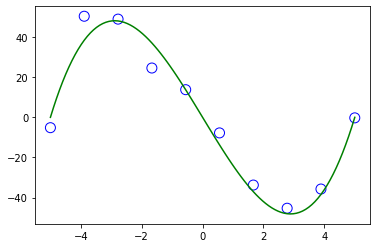

In [2]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def cubic(x):
    return x * (x - 5) * (x + 5)

def PolynomialFeature(x,degree):
    if x.ndim == 1:
        x = x[:, None]
    x_t = x.transpose()
    features = [np.ones(len(x))]
    for degree in range(1, degree + 1):
        for items in itertools.combinations_with_replacement(x_t, degree):
            features.append(functools.reduce(lambda x, y: x * y, items))
    return np.asarray(features).transpose()

x_train, y_train = create_toy_data(cubic, 10, 10., [-5, 5])
x = np.linspace(-5, 5, 100)
y = cubic(x)

feature = PolynomialFeature(x,degree=3)
X_train = PolynomialFeature(x_train, degree=3)
X = PolynomialFeature(x, degree=3)

plt.scatter(x_train, y_train, s=100, facecolor="none", edgecolor="b")
plt.plot(x, y, c="g", label="$\sin(2\pi x)$")
plt.show()

1. Write down the joint distribution of all of the variables $p(\mathbf{t}, \mathbf{w}, \alpha)$.


$$
p(\mathbf{t}, \mathbf{w}, \alpha) 
= p(\mathbf{t} | \mathbf{w})p(\mathbf{w} | \alpha)p(\alpha)
$$

2. Using the variational framework we would like to find an approximation for the posterior distribution $p(\mathbf{w}, \alpha|\mathbf{t})$. Write down the steps (parameter updates at every iteration) for the variational inference algorithm in the case of Bayesian linear regression.



Posterior distribution:
$$
p(\mathbf{w}, \alpha|\mathbf{t})
$$

Posterior distribution with factorized expression:
$$
q(\mathbf{w},\alpha)
= q(\mathbf{w})q(\alpha)
$$

Variational framework 

1. Find optimal $q$* and keep terms dependent on $\alpha$
    $$
    ln (q^*(\alpha)) 
    = ln(p(\alpha))+ E_{\mathbf{w}}[ln(p(\mathbf{w}|\alpha))] + constant
    $$ 
    $$
    = (a_0 - 1) ln(\alpha)- b_0\alpha + \frac{M}{2}ln(\alpha) - \frac{\alpha}{2}E[\mathbf{w}^T\mathbf{w}] + constant
    $$
    this is equal to the logarithm of gamma, so, 
    $$
    exp(ln(q^*(\alpha)) ) 
    = q^*(\alpha) = Gam(a_N, b_N)
    $$
    with: 
    $
    a_N
    = a_0 + \frac{M}{2}
    $,
    $
    b_N
    = b_0 + \frac{1}{2}E[\mathbf{w}^T\mathbf{w}]
    $
2. Find optimal $q$* and keep terms dependent on $\mathbf{w}$
    $$
    ln (q^*(\mathbf{w})) 
    = ln(p(\mathbf{t}|\mathbf{w}))+ E_{\alpha}[ln(p(\mathbf{w}|\alpha))] + constant
    $$
    $$
    = \frac{-\beta}{2}\sum_{n=1}^{N}\{ \mathbf{w}^T \phi_n - t_n \}^2 - \frac{1}{2} E[\alpha]\mathbf{w}^T\mathbf{w} + constant
    $$
    $$
    = \frac{-1}{2}\mathbf{w}^T(E[\alpha]\mathbf{I} + \beta\Phi^T\Phi)\mathbf{w} + \beta\mathbf{w}^T\Phi^T t + constant
    $$
    this is equal to the logarithm of gaussian, so, 
    $$
    exp(ln(q^*(\mathbf{w})) ) 
    = q^*(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)
    $$
    with: 
    $
    \mathbf{m}_N
    = \beta \mathbf{S}_N \Phi^T t
    $,
    $
    \mathbf{S}_N
    = (E[\alpha]\mathbf{I} + \beta\Phi^T\Phi)^{-1}
    $
3. This will lead to
    $$
    E[\mathbf{w}^T\mathbf{w}]
    = \mathbf{m}_N \mathbf{m}_N^T + \mathbf{S}_N
    $$
    $$
    E[\alpha]
    = \frac{a_N}{b_N}
    = \frac{M/2}{E[\mathbf{w}^T\mathbf{w}]/2}
    = \frac{M}{\mathbf{m}_N + \mathbf{m}_N^T + Tr(\mathbf{S}_N)}
    $$
4. Predictions for linear regression
    $$
    p(t| \mathbf{x},\mathbf{t})
    = \mathcal{N}(t|\mathbf{m}_N^T\phi(\mathbf{x}), \sigma^2(\mathbf{x}))
    $$
    with, 
    $$
    \sigma^2(\mathbf{x})
    = \frac{1}{\beta} + \phi(\mathbf{x})^T \mathbf{S}_N \phi(\mathbf{x})
    $$

3. Implement the variational inference algorithm for Bayesian linear regression.

In [4]:
import scipy.special as sc

In [5]:
def VariationalRegression(X, t, beta=0.01, a0 = 1e-2, b0 = 1e-4, c0 = 1e-2, d0 = 1e-4, iter_max:int=100):
    """
    Variational Bayesian estimation for linear regression.

    Parameters
    ----------
    X : (N, M) np.ndarray
        training independent variable
    t : (N,) np.ndarray
        training dependent variable
    beta : float
        precision of observation noise (assumed to be known)
    a0 : float
        a parameter of prior gamma distribution Gamma(alpha|a0,b0)
    b0 : float
        another parameter of prior gamma distribution Gamma(alpha|a0,b0)    
    iter_max : int, optional
        maximum number of iteration (the default is 100)
    
    Returns
    -------
    w_mean : mean of the variational posterior of w
    w_variance: covarioance of the variational posterior of w
    a: parameter of the variational posterior of alpha
    b: parameter of the variational posterior of beta
    """
    max_iter = iter_max
    N,M = np.shape(X)

    an = a0 + M / 2
    bn = b0
    beta = 0.01

    #100.102
    E_a = a0 / b0
    I = np.eye(M)

    bn = b0

    for it in range(0,max_iter):
        #10.101
        SN=np.linalg.inv(np.dot(E_a,I)+beta*np.dot(X.T,X)) 
        #10.100
        mN=np.dot(beta*SN,np.dot(X.T,y))
        #100.103
        bn = bn + np.dot(mN,mN.T) + np.trace(SN)
        E_a = an / bn

    return mN, SN, an, bn
    
w_mu,w_std, a,b = VariationalRegression(X,y)

4. Implement the predictive distribution over $t$ given a new data point ($x$) (see equation 10.105) in Bishop.

In [6]:
def predict(X, w_mean, w_variance, beta=0.01):
        """
        Make a prediction based on the input.

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable

        Returns
        -------
        y : (N,) np.ndarray
            mean of predictive distribution
        y_std : (N,) np.ndarray
            standard deviation of predictive distribution
        """
        y = []
        y_std = []
        for value in X:
            mu = np.dot(w_mean, value) 
            sigma_2 = 1/beta + np.dot(value, np.dot(w_variance.T,value.T))
            y.append(float(mu))
            y_std.append(float(sigma_2))
        return np.array(y), np.array(y_std)

add = PolynomialFeature(np.linspace(-5, 5, 1), degree=3)
predict(add, w_mu, w_std)

(array([0.00113511]), array([114.85755007]))

5. Plot the predictive distribution (both mean and standard deviation) for the following situations: maximum iterations in the variational inference algorithm set to 1, 2, 3, 5, 10.

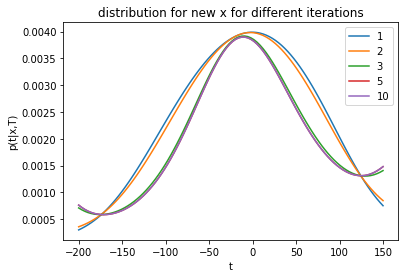

In [7]:
"""
Plot predictive distributions.
"""
from scipy.stats import norm
for iters in [1,2,3,5,10]:
    w_mu,w_std, a,b = VariationalRegression(X,y,iter_max=iters)
    y_hat, y_hat_std = predict(X, w_mu, w_std)
    lins = np.linspace(-200,150,100)
    gauss = norm(y_hat, y_hat_std).pdf(lins)
    plt.plot(lins, gauss, label = iters)
plt.legend()
plt.title('distribution for new x for different iterations')
plt.xlabel('t')
plt.ylabel('p(t|x,T)')
plt.show()

Comment on the results, in particular on the speed of convergence.

10 itterations gives an approximation which is really good, but only 1 itteration is already not that far off.

6. One of the quantities of interest in variational inference is the variational lower bound. The lower bound for Bayesian linear regression is given in Bishop in equations (10.107) - (10.112). Assume $a_{0}=0$ and $b_{0}=0$. Implement the function that computes the variational lower bound.  

In [8]:
import scipy.special as sc
import scipy
def LB(X, t, M, a, b, w_mean, w_var, beta=0.01, a0=0, b0=0):
        """
        Compute the variational lower bound.

        Parameters
        X : (N, M) np.ndarray
            training independent variables
        t : (N,) np.ndarray
            training dependent variable
        M : integer
            order of the polynomial
        beta : float
            precision of observation noise (assumed to be known)
        a0 : float
            a parameter of the prior gamma distribution Gamma(alpha|a0,b0)
        b0 : float
            another parameter of the prior gamma distribution Gamma(alpha|a0,b0)
        a : float
            a parameter of the posterior gamma distribution Gamma(alpha|a,b)
        b : float
            another parameter of the posterior gamma distribution Gamma(alpha|a,b)

        w_mean: float
            the mean of the variational posterior distribution of the weights
        w_var: float
            the variance of the covariance posterior distribution of the weights

        Returns
        -------
        LB : lower bound
        """
        N, D = np.shape(X)

        E_a = a/b
        mN = w_mean
        sN = w_var
        
        #10.108
        E_ln_ptw = -(N/2) * np.log(2/np.pi) + (N/2) * (sc.psi(a)-np.log(beta))- (a/(2*beta))*(np.dot(mN.T,mN)+np.trace(sN)) 

        #10.109
        E_WWT = np.dot(mN,mN.T)+np.trace(sN)
        E_ln_pwa = -0.5 * N * np.log(2*np.pi) + 0.5 * N * (sc.psi(a) - np.log(b)) - 0.5 * E_a * E_WWT 

        #10.110
        E_ln_pa = a0*np.log(b0+0.00001) + (a0-1)*(sc.psi(a) - np.log(b)) - b0*(a/b) - sc.gammaln(a)

        #10.111
        E_ln_qw = -0.5*np.log(np.linalg.det(sN)) + (M/2)*(1+np.log(2*np.pi))

        #10.112
        E_ln_qa = -sc.gammaln(a) - (a-1)*sc.psi(a) - np.log(b) - a
            
        #10.107
        LB = E_ln_ptw + E_ln_pwa + E_ln_pa - E_ln_qw - E_ln_qa

        return LB

7. Produce a plot of the lower bound against different orders of the polynomial (see fig. 10.9 in Bishop as an example).

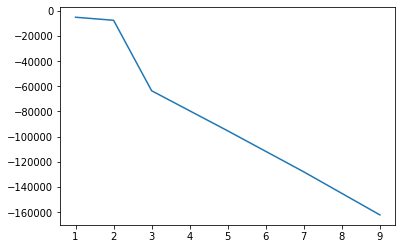

In [9]:
"""
Plot the lower bound versus different orders of polynomials.
"""
LowerBound = []
for i in [1,2,3,5,7,9]:
    X_p = PolynomialFeature(x,degree=i)
    w_mu,w_std, a,b = VariationalRegression(X_p,y)
    y_hat, y_hat_std = predict(X_p, w_mu, w_std)
    LowerBound_i = LB(X_p, y_hat, M=i, a=a, b=b, w_mean=w_mu, w_var=w_std)
    LowerBound.append(LowerBound_i)
plt.plot([1,2,3,5,7,9], LowerBound)

How can you use the variational lower bound for model selection in a regression problem? How would it compare to the maximum likelihood solution?

The variational lower bound could be used for model selection in regression problems, stopping when there is convergence. 
Unfortunately, this is not the case when we compute te lowerbound for different order of polynomials. 


8. What would we gain/lose by using MCMC (for example Gibbs sampling) for this problem instead of variational inference? For which types of problems is MCMC more suitable than VI? For which types of problems is VI more suitable than MCMC?

VI is faster than MCMC. VI is not asymptotically exact.
In limit, MCMC exactly approximates the target distribution
